# Dataset Formation

The downloaded data included 1 folder named **jpg** which included all the images, and **3 .txt files** (train.txt, valid.txt, test.txt) with each file including the list of all the images in along with their class.

The following code organizes the images into 3 folders **train, valid, test** for convenience. 

Number of images in: 

train =  1020  
valid =  1020  
test  =  6149  

In [1]:
import pandas as pd
import os
from shutil import copyfile

In [2]:
datadir = "oxford-102-flowers/"
folders = ["train", "test", "valid"]

In [20]:
for fold in folders:
    for i in range(0, 102):
        os.mkdir(datadir + fold + "/" + str(i))
        
    path = datadir + fold + ".csv"
    df = pd.read_csv(path, header=None)
    for i in range(len(df)):
        temp = str(df[0].iloc[i])
        src = datadir + temp
        dst = datadir + fold + "/" + str(df[1].iloc[i]) + "/" + temp[5:]
        copyfile(src, dst)

In [169]:
for fold in folders:
    path = datadir + fold + ".csv"
    df = pd.read_csv(path, header=None)
    print(fold, len(df))

train 1020
test 6149
valid 1020


In [ ]:
with open("labels.txt") as f:
    content = f.readlines()
    
content = [x.strip() for x in content] 
content = [x[1:-1] for x in content]

labels = dict()
for i in range(len(content)):
    labels[str(i)] = content[i]

with open("labels.json", "w") as outfile: 
    json.dump(labels, outfile)

# Importing Libraries

In [26]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import json
import copy
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
from PIL import Image
from collections import OrderedDict
import cv2
import sys
import argparse

import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable, Function
from torchvision import datasets, models, transforms, utils
import torchvision
import torch.nn.functional as F
import torch.nn as nn

# Load Data

The following data_transform uses Data Augmentation techniques like:

1. Rotation by 45 degrees
2. Crop from original images and obtain subplots
3. Horizontal Flip

This is done in order to improve our results. The training set has less number of images. Upon data augmentation, we generate more images to be used as training data.

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
}

In [5]:
train_dir = datadir + 'train'
valid_dir = datadir + 'valid'
test_dir  = datadir + 'test'

dirs = {'train': train_dir, 
        'valid': valid_dir, 
        'test' : test_dir}

image_datasets = {x: datasets.ImageFolder(dirs[x], transform=data_transforms[x]) 
                  for x in ['train', 'valid', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True) 
               for x in ['train', 'valid', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

"labels.json" includes the class number mapped to the name of the flower.

In [6]:
with open('labels.json', 'r') as f:
    label_map = json.load(f)

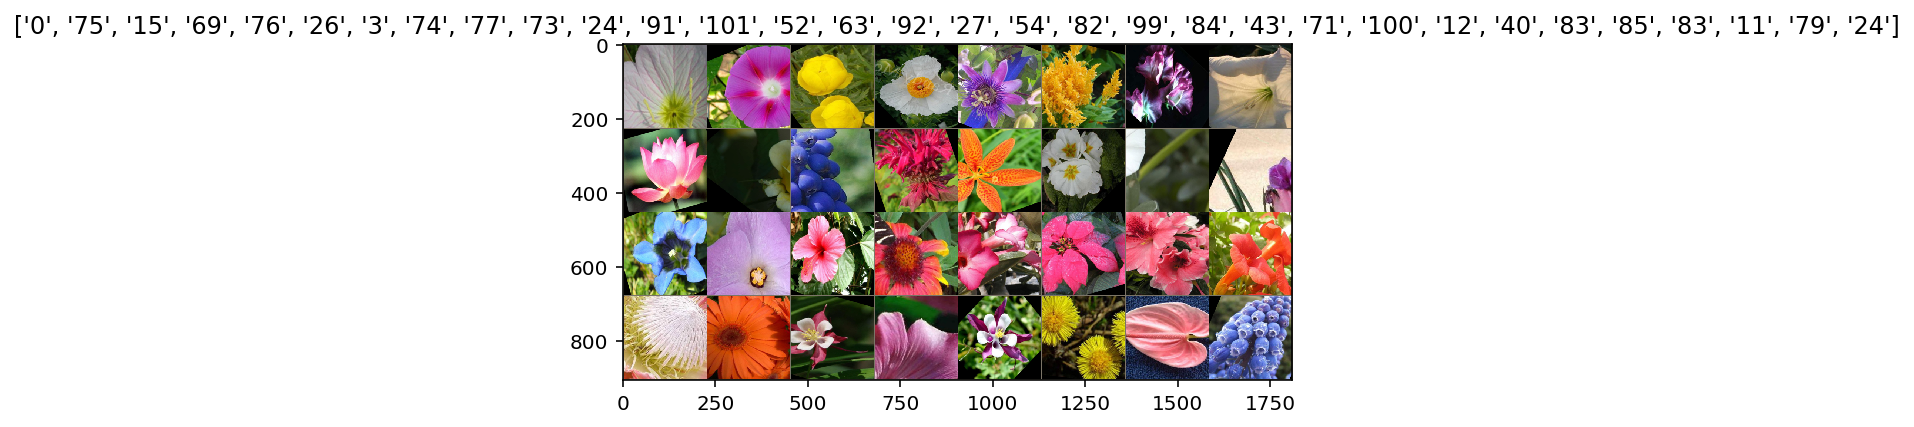

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Transfer Learning (ResNet18) and Custom Classifier

Here, we use a deeper classifier as compared to the previous version in order to improve our model.

In [8]:
class FFClassifier(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 4096)
        self.fc2 = nn.Linear(4096, out_features)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x   

In [9]:
model_conv = models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = FFClassifier(num_ftrs, 102)

model_conv = model_conv.to(device)

# Model Training

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, device='cuda'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
# Criteria NLLLoss which is recommended with Softmax final layer
criteria = nn.NLLLoss()

# # Observe that all parameters are being optimized
optimizer = optim.Adam(model_conv.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 4 epochs
sched = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

# Number of epochs
eps=25

In [12]:
model_ft = train_model(model_conv, criteria, optimizer, sched, eps, device)

Epoch 0/24
----------
train Loss: 4.5194 Acc: 0.0882
valid Loss: 3.3413 Acc: 0.4118

Epoch 1/24
----------
train Loss: 2.8644 Acc: 0.3873
valid Loss: 1.9213 Acc: 0.5647

Epoch 2/24
----------
train Loss: 1.7682 Acc: 0.5735
valid Loss: 1.3436 Acc: 0.6853

Epoch 3/24
----------
train Loss: 1.1538 Acc: 0.7745
valid Loss: 1.0069 Acc: 0.7873

Epoch 4/24
----------
train Loss: 1.0098 Acc: 0.8020
valid Loss: 0.9306 Acc: 0.8020

Epoch 5/24
----------
train Loss: 0.9300 Acc: 0.8275
valid Loss: 0.8907 Acc: 0.8029

Epoch 6/24
----------
train Loss: 0.9068 Acc: 0.8186
valid Loss: 0.8536 Acc: 0.8127

Epoch 7/24
----------
train Loss: 0.8366 Acc: 0.8304
valid Loss: 0.8469 Acc: 0.8176

Epoch 8/24
----------
train Loss: 0.8303 Acc: 0.8471
valid Loss: 0.8435 Acc: 0.8137

Epoch 9/24
----------
train Loss: 0.8490 Acc: 0.8265
valid Loss: 0.8418 Acc: 0.8196

Epoch 10/24
----------
train Loss: 0.8367 Acc: 0.8402
valid Loss: 0.8343 Acc: 0.8206

Epoch 11/24
----------
train Loss: 0.8129 Acc: 0.8382
valid Loss

# Testing

In [13]:
def calc_accuracy(model, data, cuda=False):
    model.eval()
    model.to(device) 
    
    combined_predictions = []
    combined_true_labels = []
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloaders[data]):
            if cuda:
                inputs, labels = inputs.cuda(), labels.cuda()
            
            # obtain the outputs from the model
            outputs = model.forward(inputs)
            
            # max provides the (maximum probability, max value)
            _, predicted = outputs.max(dim=1)
            
            # check the 
            if idx == 0:
                print("predicted class: ", predicted) #the predicted class
                print("predicted probability: ", torch.exp(_)) # the predicted probability
            
            equals = predicted == labels.data
            
            if idx == 0:
                print(equals)
            
            print(equals.float().mean())
            
            combined_predictions = combined_predictions + list(predicted)
            combined_true_labels = combined_true_labels + list(labels.data)
    
    combined_predictions = [int(i) for i in combined_predictions]
    combined_true_labels = [int(i) for i in combined_true_labels]

    return combined_predictions, combined_true_labels

### Save the model for future use

In [14]:
model_conv.class_to_idx = image_datasets['train'].class_to_idx
model_conv.cpu()
torch.save({'arch': 'resnet18',
            'state_dict': model_conv.state_dict(), 
            'class_to_idx': model_conv.class_to_idx}, 
            'classifier_V2.pth')

In [15]:
def load_model(checkpoint_path):
    chpt = torch.load(checkpoint_path)
    
    if chpt['arch'] == 'resnet18':
        model = models.resnet18(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        
        model.class_to_idx = chpt['class_to_idx']
        num_ftrs = model.fc.in_features
        model.fc = FFClassifier(num_ftrs, 102)
        model.load_state_dict(chpt['state_dict'])

        return model
    else:
        print("Sorry base architecture not recognized")

In [16]:
model = load_model('classifier_V2.pth')
predictions, true_labels = calc_accuracy(model, 'test', False)

predicted class:  tensor([ 7, 27, 97, 19, 37, 31,  7, 38, 22, 85, 75, 96, 22, 79, 46, 81, 95, 72,
        74, 76, 90, 37, 11, 94, 35, 86, 52, 12, 73,  5, 79, 83])
predicted probability:  tensor([0.5391, 0.4163, 0.4663, 0.9318, 0.5916, 0.4050, 0.3182, 0.2676, 0.9291,
        0.9463, 0.4907, 0.6551, 0.6059, 0.8235, 0.5681, 0.9077, 0.6755, 0.8900,
        0.1757, 0.8729, 0.8451, 0.9283, 0.4665, 0.4708, 0.4801, 0.1996, 0.5483,
        0.3751, 0.4276, 0.7365, 0.7122, 0.1360])
tensor([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 0, 1, 1, 1, 1], dtype=torch.uint8)
tensor(0.8125)
tensor(0.8125)
tensor(0.8125)
tensor(0.7188)
tensor(0.8125)
tensor(0.6250)
tensor(0.8438)
tensor(0.7812)
tensor(0.8125)
tensor(0.8750)
tensor(0.7812)
tensor(0.8125)
tensor(0.8125)
tensor(0.8125)
tensor(0.8125)
tensor(0.9062)
tensor(0.8438)
tensor(0.6875)
tensor(0.7188)
tensor(0.7500)
tensor(0.8750)
tensor(0.8438)
tensor(0.7812)
tensor(0.5625)
tensor(0.7188)
tensor(0.9375)
te

# View Images and Some Results

In [17]:
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    from PIL import Image
    img = Image.open(image_path)
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img

In [18]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

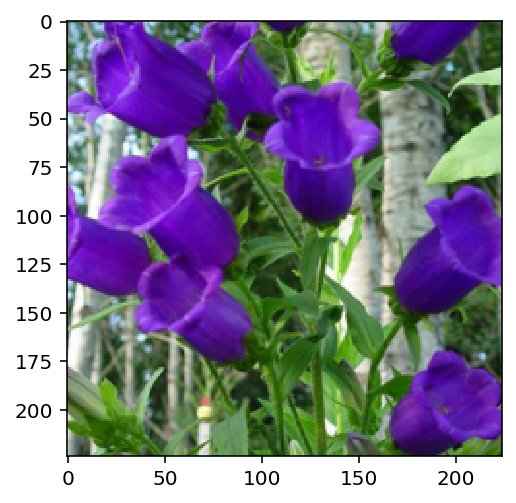

In [41]:
image_path = datadir + 'test/2/mage_06633.jpg'
img = process_image(image_path)
imshow(img)

In [20]:
def predict(image_path, model, top_num=5):
    # Process image
    img = process_image(image_path)
    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    
    # Probs
    probs = torch.exp(model.forward(model_input))
    
    # Top probs
    top_probs, top_labs = probs.topk(top_num)
    top_probs = top_probs.detach().numpy().tolist()[0] 
    top_labs = top_labs.detach().numpy().tolist()[0]
    
    # Convert indices to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [label_map[idx_to_class[lab]] for lab in top_labs]
    return top_probs, top_labels, top_flowers

In [27]:
def plot_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    
    # Set up title
    flower_num = image_path.split('/')[2]
    title_ = label_map[flower_num]
    
    # Plot flower
    img = process_image(image_path)
    imshow(img, ax, title = title_);
    
    # Make prediction
    probs, labs, flowers = predict(image_path, model) 
    
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()

def plot_solution_modified(image_path, model):
    # Set up plot
    # plt.figure(figsize = (6,10))
    # ax = plt.subplot(2,1,1)
    
    # Set up title
    flower_num = image_path.split('/')[2]
    title_ = label_map[flower_num]
    
    # Plot flower
    img = process_image(image_path)
    # imshow(img, ax, title = title_);
    
    # Make prediction
    probs, labs, flowers = predict(image_path, model) 
    
    # Plot bar chart
    # plt.subplot(2,1,2)
    # sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    # plt.show()
    
    return labs[0]

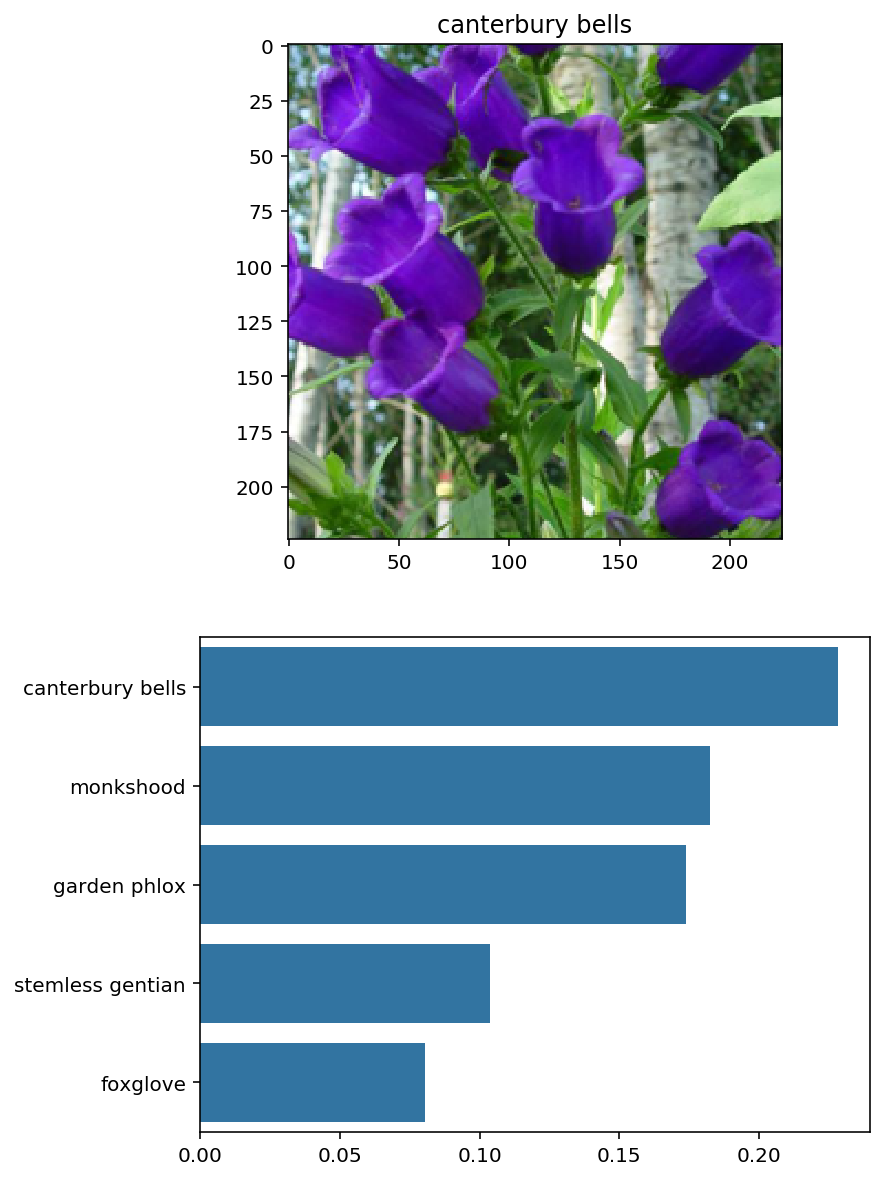

In [42]:
image_path = datadir + 'test/2/mage_06633.jpg'
plot_solution(image_path, model)

# Getting the accuracy of each flower class

Here, Accuracy = (Number of right predictions of the class) / (Number of observations of the class)

In [28]:
prd = []
tl = []

for i in range(102):
    ip = datadir + 'test/' + str(i) + '/'
    x = os.walk(ip)
    filenames = []

    for root,dirs,filename in x:
        filenames = filename

    for file in filenames:
        # print(plot_solution_modified(ip + file, model))
        prd.append(plot_solution_modified(ip + file, model))
        tl.append(i)

In [29]:
prd = [int(i) for i in prd]

results = pd.DataFrame({"class": list(range(102))})

temp_act = list(np.zeros(102))
temp_pred = list(np.zeros(102))
temp_acc = []

for i in range(len(prd)):
    temp_act[tl[i]] += 1
    if prd[i] == tl[i]:
        temp_pred[tl[i]] += 1

temp_act = [int(i) for i in temp_act] 
temp_pred = [int(i) for i in temp_pred]

for i in range(len(temp_act)):
    temp_acc.append(temp_pred[i]/temp_act[i])

results["actual"] = pd.DataFrame(temp_act)
results["correctly_predicted"] = pd.DataFrame(temp_pred)
results["accuracy"] = pd.DataFrame(temp_acc)

### Getting the weakest class based on the accuracy

In [30]:
# Getting index of the class with minimum accuracy
min_idx = results["accuracy"].idxmin() 
min_idx

2

### Accuracy

In [31]:
print('Accuracy = ', np.mean(results["accuracy"]))

Accuracy =  0.8159778965354642


# GradCAM

In [35]:
i=0 ## testing in what

resnet = load_model('classifier_V2.pth')
image = []

class FeatureExtractor():
    """ Class for extracting activations and 
    registering gradients from targetted intermediate layers """
    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
    	self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            #print('name=',name)
            #print('x.size()=',x.size())
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
            #print('outputs.size()=',x.size())
        #print('len(outputs)',len(outputs))
        return outputs, x

class ModelOutputs():
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermeddiate targetted layers.
    3. Gradients from intermeddiate targetted layers. """
    def __init__(self, model, target_layers,use_cuda):
        self.model = model
        self.feature_extractor = FeatureExtractor(self.model, target_layers)
        self.cuda = use_cuda
    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations, output  = self.feature_extractor(x)
        output = output.view(output.size(0), -1)
        #print('classfier=',output.size())
        if self.cuda:
            output = output.cpu()
            output = resnet.fc(output).cuda()
        else:
            output = resnet.fc(output)
        return target_activations, output

def preprocess_image(img):
    means=[0.485, 0.456, 0.406]
    stds=[0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[: , :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img)
    preprocessed_img.unsqueeze_(0)
    input = preprocessed_img
    input.requires_grad = True
    return input

def show_cam_on_image_modified(img, mask, name):
    heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    cv2.imwrite("cam_V2/cam_{}.jpg".format(name), np.uint8(255 * cam))


class GradCam:
    def __init__(self, model, target_layer_names, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(self.model, target_layer_names, use_cuda)

    def forward(self, input):
        return self.model(input) 

    def __call__(self, input, index = None):
        if self.cuda:
            features, output = self.extractor(input.cuda())
        else:
            features, output = self.extractor(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype = np.float32)
        one_hot[0][index] = 1
        one_hot = torch.Tensor(torch.from_numpy(one_hot))
        one_hot.requires_grad = True
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        self.model.zero_grad()
        one_hot.backward(retain_graph=True)
        
        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()
        #print('grads_val',grads_val.shape)
        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis = (2, 3))[0, :]
        #print('weights',weights.shape)
        cam = np.zeros(target.shape[1 : ], dtype = np.float32)
        #print('cam',cam.shape)
        #print('features',features[-1].shape)
        #print('target',target.shape)
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam
    
    
class GuidedBackpropReLUModel:
    def __init__(self, model, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        for module in self.model.named_modules():
            module[1].register_backward_hook(self.bp_relu)

    def bp_relu(self, module, grad_in, grad_out):
        if isinstance(module, nn.ReLU):
            return (torch.clamp(grad_in[0], min=0.0),)
        
    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index = None):
        if self.cuda:
            output = self.forward(input.cuda())
        else:
            output = self.forward(input)
        if index == None:
            index = np.argmax(output.cpu().data.numpy())
        #print(input.grad)
        one_hot = np.zeros((1, output.size()[-1]), dtype = np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot)
        one_hot.requires_grad = True
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)
        #self.model.classifier.zero_grad()
        one_hot.backward(retain_graph=True)
        output = input.grad.cpu().data.numpy()
        output = output[0,:,:,:]

        return output

In [36]:
model2 = load_model("classifier_V2.pth")
del model2.fc
print(model2)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [37]:
datadir = "oxford-102-flowers/"

grad_cam = GradCam(model2 , target_layer_names = ["layer4"], use_cuda=False)
x=os.walk(datadir + "test/" + str(min_idx) + "/")

for root,dirs,filename in x:
    #print(type(grad_cam))
    print(filename)

for s in filename:
    image.append(cv2.imread(datadir + "test/" + str(min_idx) + "/" + s, 1))
    #img = cv2.imread(filename, 1)

['mage_06613.jpg', 'mage_06617.jpg', 'mage_06615.jpg', 'mage_06629.jpg', 'mage_06628.jpg', 'mage_06649.jpg', 'mage_06648.jpg', 'mage_06650.jpg', 'mage_06641.jpg', 'mage_06643.jpg', 'mage_06619.jpg', 'mage_06625.jpg', 'mage_06627.jpg', 'mage_06633.jpg', 'mage_06637.jpg', 'mage_06622.jpg', 'mage_06636.jpg', 'mage_06620.jpg', 'mage_06635.jpg', 'mage_06621.jpg']


In [38]:
for img in image:
    img = np.float32(cv2.resize(img, (224, 224))) / 255
    
    input = preprocess_image(img)
    input.required_grad = True
    print('input.size()=',input.size())
    # If None, returns the map for the highest scoring category.
    # Otherwise, targets the requested index.
    target_index = None

    mask = grad_cam(input, target_index)
    i=i+1 
    
    if not os.path.exists('cam_V2'):
        os.mkdir('cam_V2')
    
    show_cam_on_image_modified(img, mask, i)

    gb_model = GuidedBackpropReLUModel(model = models.resnet18(pretrained=True), use_cuda=False)
    gb = gb_model(input, index=target_index)
    
    if not os.path.exists('gb_V2'):
        os.mkdir('gb_V2')
    
    if not os.path.exists('camgb_V2'):
        os.mkdir('camgb_V2')
    
    utils.save_image(torch.from_numpy(gb), 'gb_V2/gb_{}.jpg'.format(i))
    cam_mask = np.zeros(gb.shape)
    
    for j in range(0, gb.shape[0]):
        cam_mask[j, :, :] = mask
    
    cam_gb = np.multiply(cam_mask, gb)
    utils.save_image(torch.from_numpy(cam_gb), 'camgb_V2/cam_gb_{}.jpg'.format(i))

input.size()= torch.Size([1, 3, 224, 224])
input.size()= torch.Size([1, 3, 224, 224])
input.size()= torch.Size([1, 3, 224, 224])
input.size()= torch.Size([1, 3, 224, 224])
input.size()= torch.Size([1, 3, 224, 224])
input.size()= torch.Size([1, 3, 224, 224])
input.size()= torch.Size([1, 3, 224, 224])
input.size()= torch.Size([1, 3, 224, 224])
input.size()= torch.Size([1, 3, 224, 224])
input.size()= torch.Size([1, 3, 224, 224])
input.size()= torch.Size([1, 3, 224, 224])
input.size()= torch.Size([1, 3, 224, 224])
input.size()= torch.Size([1, 3, 224, 224])
input.size()= torch.Size([1, 3, 224, 224])
input.size()= torch.Size([1, 3, 224, 224])
input.size()= torch.Size([1, 3, 224, 224])
input.size()= torch.Size([1, 3, 224, 224])
input.size()= torch.Size([1, 3, 224, 224])
input.size()= torch.Size([1, 3, 224, 224])
input.size()= torch.Size([1, 3, 224, 224])


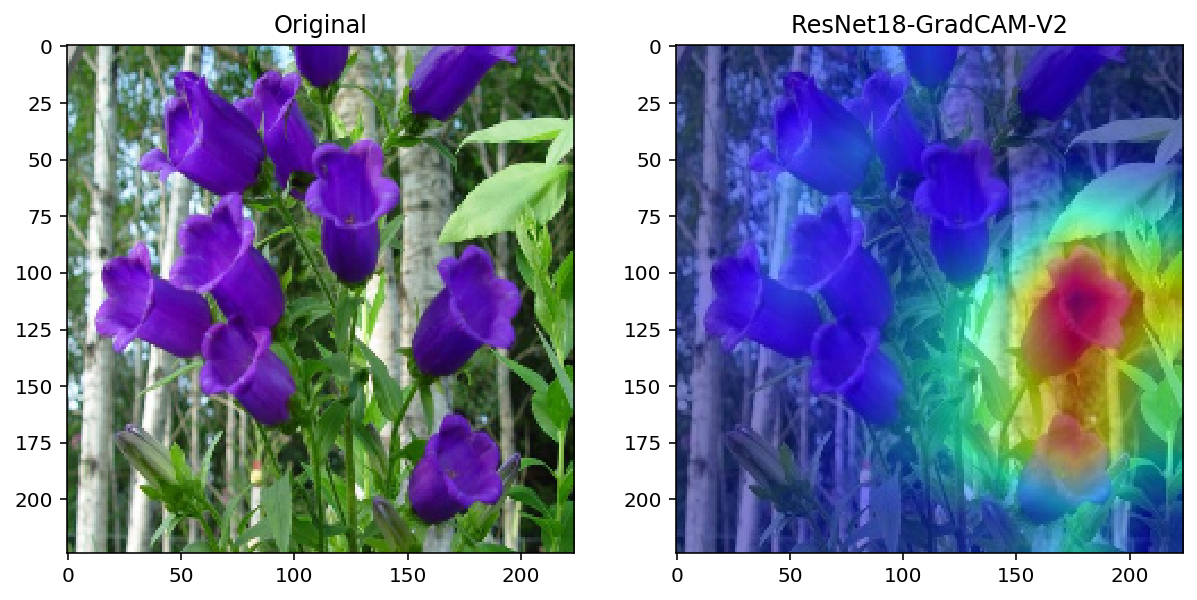

In [44]:
# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 1
columns = 2
  
# reading images
Image1 = cv2.cvtColor(cv2.imread(datadir + 'test/2/mage_06633.jpg'), cv2.COLOR_BGR2RGB)
Image2 = cv2.cvtColor(cv2.imread('cam_V2/cam_14.jpg'), cv2.COLOR_BGR2RGB)
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(cv2.resize(Image1, (224, 224)))
# plt.axis('off')
plt.title("Original")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(Image2)
# plt.axis('off')
plt.title("ResNet18-GradCAM-V2")

plt.show()